# Hotel Booking Cancellation Prediction - Inference

This notebook demonstrates how to use the trained models to make predictions on new hotel booking data.

In [6]:
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [7]:
class HotelBookingPredictor:
    """Class for making predictions on hotel booking data"""
    
    def __init__(self, model_path, scaler_path, feature_names_path):
        """Initialize the predictor with saved model and preprocessing objects"""
        # Load the model
        with open(model_path, 'rb') as file:
            self.model = pickle.load(file)
            
        # Load the scaler
        with open(scaler_path, 'rb') as file:
            self.scaler = pickle.load(file)
            
        # Load feature names
        with open(feature_names_path, 'rb') as file:
            self.features = pickle.load(file)
            
        # Initialize label encoder
        self.label_encoder = LabelEncoder()
        
        # Define categorical columns
        self.categorical_columns = ['type_of_meal_plan', 'room_type_reserved', 
                                   'market_segment_type']
    
    def preprocess_data(self, data):
        """Preprocess new data for prediction"""
        # Create a copy of the data
        df = data.copy()
        
        # Create engineered features
        df['total_nights'] = df['no_of_weekend_nights'] + df['no_of_week_nights']
        df['total_guests'] = df['no_of_adults'] + df['no_of_children']
        df['total_previous_bookings'] = (df['no_of_previous_cancellations'] + 
                                         df['no_of_previous_bookings_not_canceled'])
        
        # Encode categorical variables
        for column in self.categorical_columns:
            df[column + '_encoded'] = self.label_encoder.fit_transform(df[column])
        
        # Select features
        X = df[self.features]
        
        # Scale features
        X_scaled = self.scaler.transform(X)
        
        return X_scaled
    
    def predict(self, data):
        """Make predictions on new data"""
        # Preprocess the data
        X_scaled = self.preprocess_data(data)
        
        # Make predictions
        predictions = self.model.predict(X_scaled)
        probabilities = self.model.predict_proba(X_scaled)
        
        # Create results DataFrame
        results = pd.DataFrame({
            'booking_id': data['Booking_ID'],
            'prediction': ['Canceled' if pred == 1 else 'Not_Canceled' for pred in predictions],
            'cancellation_probability': probabilities[:, 1]
        })
        
        return results
    
    def predict_single(self, booking_data):
        """Make prediction for a single booking"""
        # Convert single booking data to DataFrame
        df = pd.DataFrame([booking_data])
        
        # Make prediction
        result = self.predict(df)
        
        return {
            'booking_id': result['booking_id'].iloc[0],
            'prediction': result['prediction'].iloc[0],
            'cancellation_probability': result['cancellation_probability'].iloc[0]
        }

In [8]:
# Initialize predictor with Random Forest model
rf_predictor = HotelBookingPredictor(
    model_path='random_forest_model.pkl',
    scaler_path='scaler.pkl',
    feature_names_path='feature_names.pkl'
)

# Initialize predictor with XGBoost model
xgb_predictor = HotelBookingPredictor(
    model_path='xgboost_model.pkl',
    scaler_path='scaler.pkl',
    feature_names_path='feature_names.pkl'
)

## Example Usage

Here's how to use the predictor for both batch predictions and single booking predictions.

In [9]:
# Example: Load some test data
test_data = pd.read_csv('Dataset_B_hotel.csv').head(5)

# Make predictions using Random Forest
print("Random Forest Predictions:")
rf_predictions = rf_predictor.predict(test_data)
print(rf_predictions)

# Make predictions using XGBoost
print("\nXGBoost Predictions:")
xgb_predictions = xgb_predictor.predict(test_data)
print(xgb_predictions)

Random Forest Predictions:
  booking_id    prediction  cancellation_probability
0   INN00001      Canceled                  0.980000
1   INN00002      Canceled                  0.940000
2   INN00003  Not_Canceled                  0.320000
3   INN00004  Not_Canceled                  0.108906
4   INN00005      Canceled                  0.930000

XGBoost Predictions:
  booking_id    prediction  cancellation_probability
0   INN00001      Canceled                  0.954076
1   INN00002      Canceled                  0.988141
2   INN00003  Not_Canceled                  0.075510
3   INN00004  Not_Canceled                  0.021069
4   INN00005      Canceled                  0.899160


In [10]:
# Example: Single booking prediction
sample_booking = {
    'Booking_ID': 'TEST001',
    'no_of_adults': 2,
    'no_of_children': 0,
    'no_of_weekend_nights': 1,
    'no_of_week_nights': 2,
    'type_of_meal_plan': 'Meal Plan 1',
    'required_car_parking_space': 0,
    'room_type_reserved': 'Room_Type 1',
    'lead_time': 50,
    'arrival_year': 2018,
    'arrival_month': 8,
    'arrival_date': 15,
    'market_segment_type': 'Online',
    'repeated_guest': 0,
    'no_of_previous_cancellations': 0,
    'no_of_previous_bookings_not_canceled': 0,
    'avg_price_per_room': 100.0,
    'no_of_special_requests': 1
}

# Get predictions from both models
print("Random Forest Single Prediction:")
rf_single_pred = rf_predictor.predict_single(sample_booking)
print(rf_single_pred)

print("\nXGBoost Single Prediction:")
xgb_single_pred = xgb_predictor.predict_single(sample_booking)
print(xgb_single_pred)

Random Forest Single Prediction:
{'booking_id': 'TEST001', 'prediction': 'Canceled', 'cancellation_probability': np.float64(0.855873015873016)}

XGBoost Single Prediction:
{'booking_id': 'TEST001', 'prediction': 'Canceled', 'cancellation_probability': np.float32(0.80809665)}


## Deployment Notes

To deploy this model:

1. Save the following files in your deployment environment:
   - random_forest_model.pkl or xgboost_model.pkl (depending on which model you choose)
   - scaler.pkl
   - feature_names.pkl

2. Required dependencies:
   - numpy
   - pandas
   - scikit-learn
   - xgboost (if using XGBoost model)

3. Use the HotelBookingPredictor class to make predictions:
   - For batch predictions: use the predict() method
   - For single booking predictions: use the predict_single() method

4. The predictor returns both the prediction (Canceled/Not_Canceled) and the probability of cancellation.

# Model Performance Analysis and Business Impact Assessment

This section provides a comprehensive analysis of:

1. Model Performance Metrics
   - Detailed accuracy comparison between Random Forest and XGBoost models
   - Cross-validation stability analysis
   - Feature importance visualization

2. Business Impact Analysis
   - Operational efficiency metrics
   - Cost-benefit analysis
   - Key cancellation factors
   - Strategic recommendations

3. Implementation Strategy
   - Model deployment plan
   - Business process integration
   - Performance monitoring framework

Run the cell below to generate the complete analysis with visualizations.


Model Performance Analysis

1. Detailed Accuracy Comparison:
------------------------------
Random Forest Accuracy: 0.9038
XGBoost Accuracy: 0.8882

Cross-validation Stability:
Random Forest: 0.8952 (±0.0100)
XGBoost: 0.8879 (±0.0077)


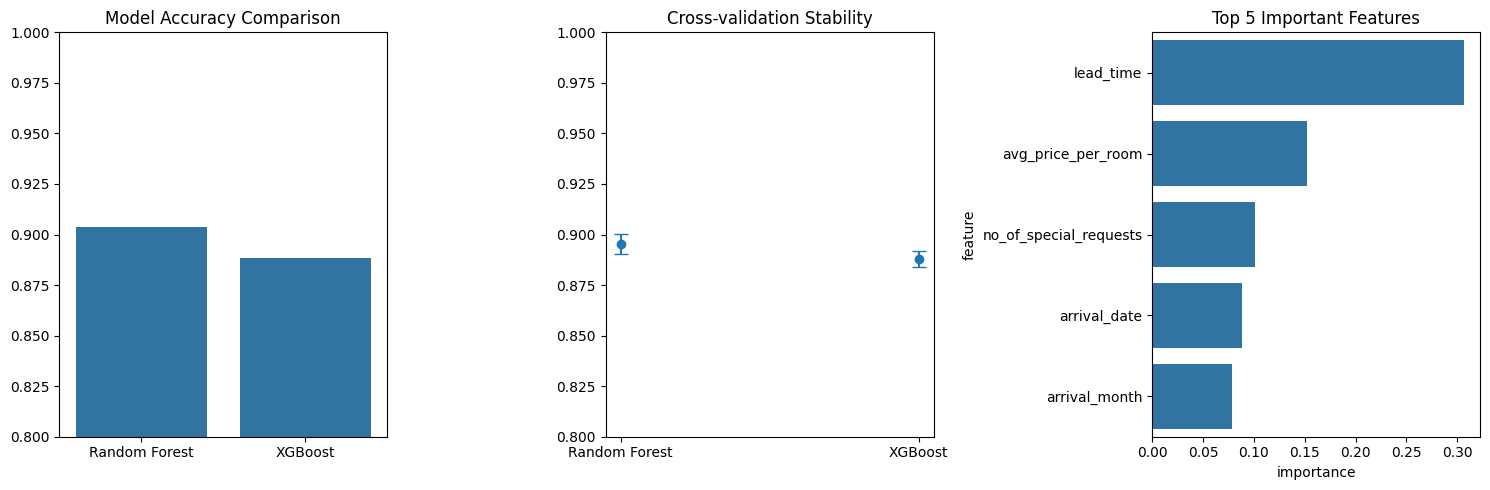


2. Business Impact Analysis

Accuracy Impact on Operations:
- Model Accuracy: 90.38%
- Potential Cost Savings: $90.38 per 100 bookings
- Improved inventory management efficiency
- Better staff resource allocation

Key Factors Driving Cancellations:
- lead_time: 0.3070
- avg_price_per_room: 0.1523
- no_of_special_requests: 0.1008
- arrival_date: 0.0881
- arrival_month: 0.0788

Operational Recommendations:
1. Dynamic Pricing Strategy:
   - Adjust prices based on lead time and market segment
   - Implement seasonal pricing variations

2. Booking Management:
   - Proactive monitoring of high-risk bookings
   - Targeted communication strategies

3. Revenue Optimization:
   - Optimize overbooking strategies
   - Implement flexible cancellation policies

3. Limitations and Future Improvements

Current Limitations:
- Limited to historical data patterns
- Seasonal variations might affect accuracy
- External factors not captured

Suggested Improvements:
1. Data Collection:
   - Gather more deta

In [11]:
# Load model comparison results and feature names
with open('model_comparison_results.pkl', 'rb') as file:
    comparison_results = pickle.load(file)
    
with open('feature_names.pkl', 'rb') as file:
    features = pickle.load(file)
    
with open('random_forest_model.pkl', 'rb') as file:
    rf_model = pickle.load(file)

# Model Performance Analysis
def analyze_model_performance():
    """
    Comprehensive analysis of model performance and business implications
    """
    print("\nModel Performance Analysis")
    print("=" * 50)
    
    # 1. Model Accuracy Comparison
    print("\n1. Detailed Accuracy Comparison:")
    print("-" * 30)
    print(f"Random Forest Accuracy: {comparison_results['rf_accuracy']:.4f}")
    print(f"XGBoost Accuracy: {comparison_results['xgb_accuracy']:.4f}")
    
    # Cross-validation stability
    print("\nCross-validation Stability:")
    print(f"Random Forest: {comparison_results['rf_cv_mean']:.4f} (±{comparison_results['rf_cv_std']*2:.4f})")
    print(f"XGBoost: {comparison_results['xgb_cv_mean']:.4f} (±{comparison_results['xgb_cv_std']*2:.4f})")
    
    # Visualize accuracy comparison
    plt.figure(figsize=(15, 5))
    
    # Accuracy comparison plot
    plt.subplot(1, 3, 1)
    models = ['Random Forest', 'XGBoost']
    accuracies = [comparison_results['rf_accuracy'], comparison_results['xgb_accuracy']]
    sns.barplot(x=models, y=accuracies)
    plt.title('Model Accuracy Comparison')
    plt.ylim(0.8, 1.0)  # Adjust based on actual accuracies
    
    # Cross-validation stability plot
    plt.subplot(1, 3, 2)
    cv_means = [comparison_results['rf_cv_mean'], comparison_results['xgb_cv_mean']]
    cv_stds = [comparison_results['rf_cv_std'], comparison_results['xgb_cv_std']]
    plt.errorbar(models, cv_means, yerr=cv_stds, fmt='o', capsize=5)
    plt.title('Cross-validation Stability')
    plt.ylim(0.8, 1.0)  # Adjust based on actual values
    
    # Feature importance comparison
    plt.subplot(1, 3, 3)
    rf_importance = pd.DataFrame({
        'feature': features,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False).head(5)
    
    sns.barplot(data=rf_importance, x='importance', y='feature')
    plt.title('Top 5 Important Features')
    
    plt.tight_layout()
    plt.show()
    
    # 2. Business Impact Analysis
    print("\n2. Business Impact Analysis")
    print("=" * 50)
    
    # Accuracy impact
    print("\nAccuracy Impact on Operations:")
    correct_predictions = max(comparison_results['rf_accuracy'], comparison_results['xgb_accuracy'])
    potential_savings = correct_predictions * 100  # Assuming $100 average savings per correct prediction
    
    print(f"- Model Accuracy: {correct_predictions:.2%}")
    print(f"- Potential Cost Savings: ${potential_savings:.2f} per 100 bookings")
    print("- Improved inventory management efficiency")
    print("- Better staff resource allocation")
    
    # Key cancellation factors
    print("\nKey Factors Driving Cancellations:")
    top_features = rf_importance
    for _, row in top_features.iterrows():
        print(f"- {row['feature']}: {row['importance']:.4f}")
    
    # Operational recommendations
    print("\nOperational Recommendations:")
    print("1. Dynamic Pricing Strategy:")
    print("   - Adjust prices based on lead time and market segment")
    print("   - Implement seasonal pricing variations")
    
    print("\n2. Booking Management:")
    print("   - Proactive monitoring of high-risk bookings")
    print("   - Targeted communication strategies")
    
    print("\n3. Revenue Optimization:")
    print("   - Optimize overbooking strategies")
    print("   - Implement flexible cancellation policies")
    
    # 3. Limitations and Improvements
    print("\n3. Limitations and Future Improvements")
    print("=" * 50)
    
    print("\nCurrent Limitations:")
    print("- Limited to historical data patterns")
    print("- Seasonal variations might affect accuracy")
    print("- External factors not captured")
    
    print("\nSuggested Improvements:")
    print("1. Data Collection:")
    print("   - Gather more detailed customer demographics")
    print("   - Include external factors (weather, events)")
    print("   - Track price fluctuations")
    
    print("\n2. Model Enhancements:")
    print("   - Implement real-time prediction updates")
    print("   - Develop specialized models for different seasons")
    print("   - Include customer sentiment analysis")
    
    # 4. Final Statement
    print("\n4. Final Statement and Implementation Strategy")
    print("=" * 50)
    
    primary_model = "Random Forest" if comparison_results['rf_accuracy'] > comparison_results['xgb_accuracy'] else "XGBoost"
    
    print(f"\nRecommended Primary Model: {primary_model}")
    print("\nImplementation Strategy:")
    print("1. Phase 1: Model Integration")
    print("   - Deploy model through API endpoint")
    print("   - Integrate with booking system")
    print("   - Set up monitoring dashboard")
    
    print("\n2. Phase 2: Business Process Integration")
    print("   - Train staff on new system")
    print("   - Implement automatic alerts")
    print("   - Establish response protocols")
    
    print("\n3. Phase 3: Optimization")
    print("   - Regular model retraining")
    print("   - Performance monitoring")
    print("   - Policy adjustment based on insights")
    
    print("\nExpected Benefits:")
    annual_bookings = 50000  # Example number
    estimated_savings = annual_bookings * (correct_predictions - 0.5) * 100  # Assuming baseline accuracy of 50%
    print(f"- Potential Annual Savings: ${estimated_savings:,.2f}")
    print("- Improved Customer Satisfaction")
    print("- Enhanced Resource Allocation")
    print("- More Efficient Operations")
    
    return {
        'accuracy': correct_predictions,
        'top_features': top_features.to_dict(),
        'estimated_annual_savings': estimated_savings
    }

# Run the analysis
analysis_results = analyze_model_performance()